# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [4]:
# your code here
bikes_df_raw = pd.read_csv('./data/BSS_hour_raw.csv', low_memory=False)
print('Length:', len(bikes_df_raw))
print(bikes_df_raw.columns)
bikes_df_raw.head(5).append(bikes_df_raw.tail(5))

Length: 17379
Index(['dteday', 'season', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered'],
      dtype='object')


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1
17374,2012-12-31,1,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108
17375,2012-12-31,1,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81
17376,2012-12-31,1,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83
17377,2012-12-31,1,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48
17378,2012-12-31,1,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37


*Your answer here*

**1.2 Notice that the variable in column...**

In [5]:
# your code here
# Convert dteday to 
bikes_df_raw['dteday'] = pd.to_datetime(bikes_df_raw['dteday'])
data_types = bikes_df_raw.dtypes
data_types[bikes_df_raw.applymap(type).eq(str).all()] = 'str'
print(data_types)

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object


**1.3 Create three new columns in the dataframe:...**

In [6]:
# your code here
bikes_df_raw['year'] = bikes_df_raw['dteday'].map(lambda x: x.year)
bikes_df_raw['month'] = bikes_df_raw['dteday'].map(lambda x: x.month)
bikes_df_raw['count'] = bikes_df_raw['casual'] + bikes_df_raw['registered']
bikes_df_raw.iloc[0]

dteday        2011-01-01 00:00:00
season                          1
hour                            0
holiday                         0
weekday                         6
workingday                      0
weather                         1
temp                         0.24
atemp                      0.2879
hum                          0.81
windspeed                       0
casual                          3
registered                     13
year                         2011
month                           1
count                          16
Name: 0, dtype: object

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

<Figure size 432x288 with 0 Axes>

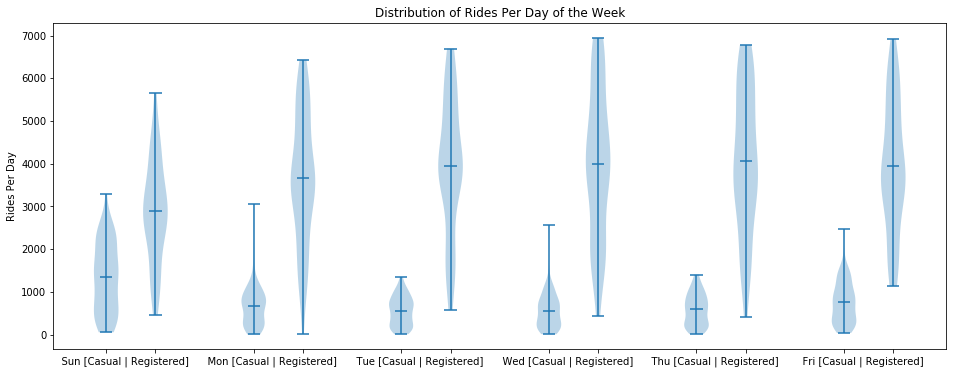

In [7]:
# your code here
bikes_by_day = bikes_df_raw.groupby('dteday').agg(
    {'weekday':'first',
     'weather':'max',
     'season':'first',
     'temp':'mean',
     'atemp':'mean',
     'windspeed':'mean',
     'hum':'mean',
     'casual':'sum',
     'registered':'sum',
     'count':'sum'})

count_per_day = list()
pos = list()
for day in range(6):
    count_per_day.append(np.array(bikes_by_day.loc[bikes_by_day['weekday'] == day]['casual']))
    pos.append(day*3)
    count_per_day.append(np.array(bikes_by_day.loc[bikes_by_day['weekday'] == day]['registered']))
    pos.append(day*3 + 1)

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
axes.violinplot(count_per_day, pos, widths=0.5, showmeans=True, showextrema=True)

axes.set_xticks(pos)
axes.set_xticklabels(['            Sun [Casual | Registered]','',
                      '            Mon [Casual | Registered]','',
                      '            Tue [Casual | Registered]','',
                      '            Wed [Casual | Registered]','',
                      '            Thu [Casual | Registered]','',
                      '            Fri [Casual | Registered]','',
                      '            Sat [Casual | Registered]',''])
axes.set_ylabel('Rides Per Day')
axes.set_title('Distribution of Rides Per Day of the Week')
plt.show()

**2.2 Use `bikes_by_day` to visualize how the distribution...**

<Figure size 432x288 with 0 Axes>

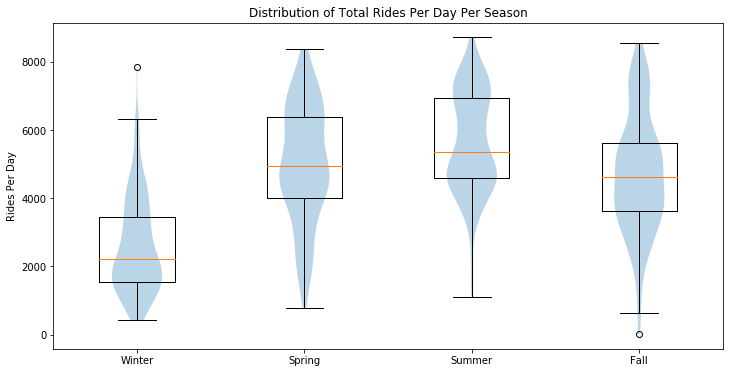

IQR Winter : 1918.0
IQR Spring : 2374.0
IQR Summer : 2342.75
IQR Fall : 2009.0

Outliers:


,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,count
dteday,,,,,,,,,,
2012-03-17,6,2,1,0.514167,0.505046,0.110704,0.755833,3155,4681,7836
2012-10-29,1,3,4,0.440000,0.439400,0.358200,0.880000,2,20,22


In [8]:
# your code here   

# Plot data for each season
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

count_per_season = list()
for season in range(1,5):
    count_per_season.append(np.array(bikes_by_day.loc[bikes_by_day['season'] == season]['count']))

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
axes.violinplot(count_per_season, widths=0.3, showextrema=False)
axes.boxplot(count_per_season)

axes.set_xticks([1,2,3,4])
axes.set_xticklabels(seasons)
axes.set_ylabel('Rides Per Day')
axes.set_title('Distribution of Total Rides Per Day Per Season')
plt.show()

# Capture Outliers
outliers_df = pd.DataFrame()
for season in range(1,5):
    season_df = bikes_by_day.loc[bikes_by_day['season'] == season]
    Q1 = season_df['count'].quantile(0.25)
    Q3 = season_df['count'].quantile(0.75)
    IQR = Q3 - Q1
    print('IQR', seasons[season - 1],':', IQR)

    outliers_df = outliers_df.append(season_df.loc[(season_df['count'] < Q1 - 1.5*IQR) | (season_df['count'] > Q3 + 1.5*IQR)])

print('\nOutliers:')
outliers_df

2012-03-17	was an unseasonably warm day and also St. Patricks day. This appears to be a legitimate data point, having extremely high rider count.

2012-10-29	was during hurricaine Sandy. This also appears to be a legitimate data-point, having extremely low ridership.

**2.3 Convert the categorical attributes...**

In [9]:
# your code here
#  ('season', 'month', 'weekday', 'weather')

print(bikes_df_raw.columns)
bikes_df = bikes_df_raw
#bikes_df = pd.concat([bikes_df, pd.get_dummies(bikes_df_raw['season'], drop_first=True)], axis=1)
bikes_df = pd.get_dummies(bikes_df_raw, columns=['season', 'month', 'weekday', 'weather'], drop_first=True)
bikes_df.rename(columns={'weekday_1':'mon', 'weekday_2':'tue', 'weekday_3':'wed',
                         'weekday_4':'thu', 'weekday_5':'fri', 'weekday_6':'sat',
                         'season_2':'spring', 'season_3':'summer','season_4':'fall'}, inplace=True)
bikes_df['month'] = bikes_df_raw['month']
bikes_df.iloc[0]

Index(['dteday', 'season', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'year', 'month', 'count'],
      dtype='object')


dteday        2011-01-01 00:00:00
hour                            0
holiday                         0
workingday                      0
temp                         0.24
atemp                      0.2879
hum                          0.81
windspeed                       0
casual                          3
registered                     13
year                         2011
count                          16
spring                          0
summer                          0
fall                            0
month_2                         0
month_3                         0
month_4                         0
month_5                         0
month_6                         0
month_7                         0
month_8                         0
month_9                         0
month_10                        0
month_11                        0
month_12                        0
mon                             0
tue                             0
wed                             0
thu           

**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [10]:
# your code here
bikes_train, bikes_test = train_test_split(bikes_df, 
                                           random_state = 90,
                                           test_size = 0.5, 
                                           stratify = bikes_df['month'])

**2.5 Although we asked you to create your train and test set...**

In [11]:
# your code here
BSS_train = pd.read_csv('./data/BSS_train.csv', low_memory=False)
BSS_test = pd.read_csv('./data/BSS_test.csv', low_memory=False)
BSS_train.head(5)

,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,casual,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,2012-12-27,21,0,1,1,0.24,0.2273,0.60,0.2537,12,...,1,0,0,0,1,0,0,1,0,0
1,2011-10-13,17,0,0,1,0.62,0.5758,0.83,0.2537,47,...,0,0,0,0,1,0,0,0,1,0
2,2012-08-09,9,0,1,1,0.76,0.7273,0.66,0.1642,54,...,0,0,0,0,1,0,0,0,0,0
3,2012-04-08,17,0,1,0,0.62,0.6061,0.22,0.2985,185,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-29,8,0,1,0,0.18,0.1970,0.40,0.1343,9,...,0,0,0,0,0,0,0,0,0,0


**2.6 Use pandas' `scatter_matrix` command to visualize...**

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

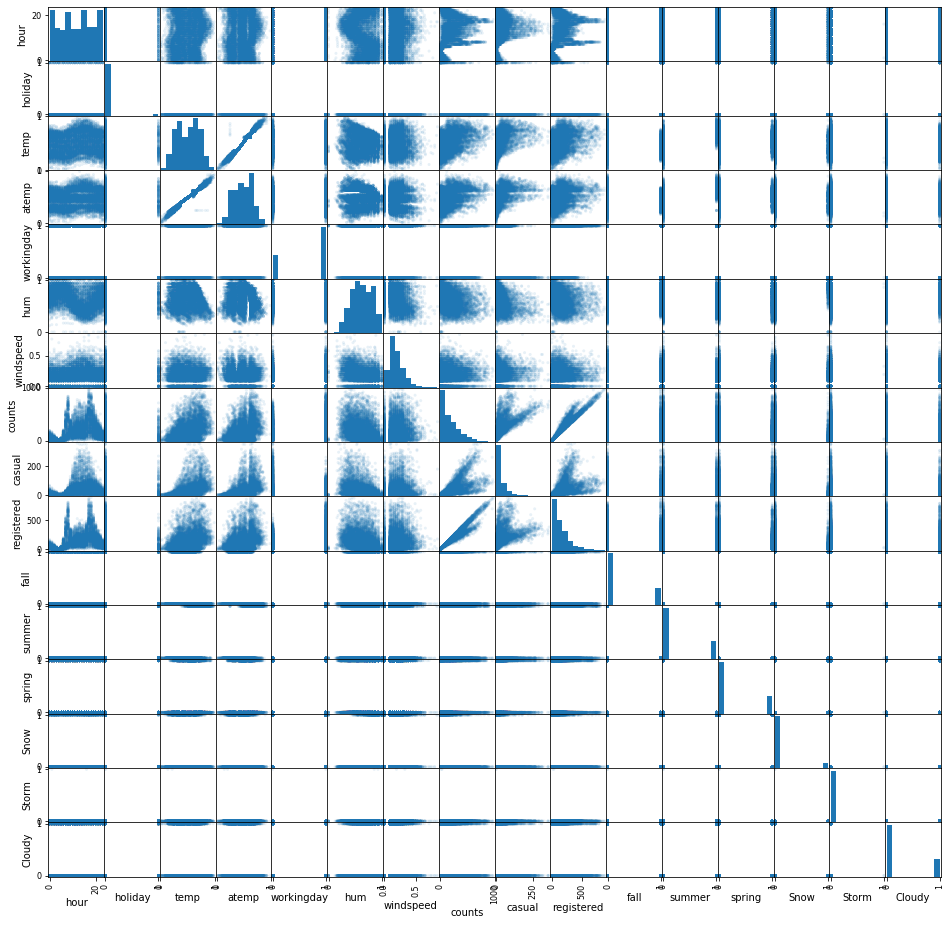

In [12]:
# your code here
plt.clf()
fig = plt.figure()
fig.subplots_adjust(hspace=1, wspace=1)
scatter_matrix(BSS_train[
                ['hour', 'holiday', 'temp', 'atemp', 
                 'workingday', 'hum', 'windspeed', 
                 'counts', 'casual', 'registered',
                 'fall', 'summer', 'spring', 
                 'Snow', 'Storm', 'Cloudy']],
                alpha = 0.1,
                figsize=(16, 16))
plt.show()

Naturally, temperature appears highly correlated with apparent temperature. This is expected and we likely only want to include one of these in our future regression analysis.

Counts, registered, and casual are all highly correlated. This makes sense, as they are all effectively dependant variables. 

Both 'hour' and 'temperature' appear to have slight positive correlation with 'count'. This makes intuitive sense, as bikes would likely be used more in warmer weather, and more throughout the day.

There also seems to be a negative correlation with Snow.

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

<Figure size 432x288 with 0 Axes>

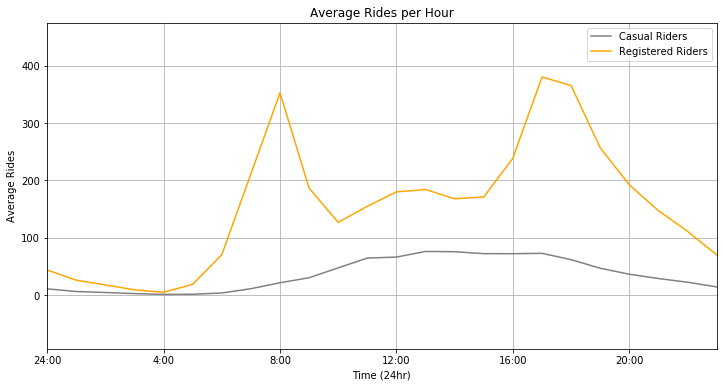

In [13]:
# your code here
bikes_by_hour = BSS_train.groupby('hour').agg(
    {'casual':'mean',
     'registered':'mean'})

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.grid(True)
plt.margins(0, 0.25)
plt.plot(bikes_by_hour.index, bikes_by_hour.casual, label = 'Casual Riders', color = 'grey')
plt.plot(bikes_by_hour.index, bikes_by_hour.registered, label = 'Registered Riders', color = 'orange')
plt.title('Average Rides per Hour')
plt.ylabel('Average Rides')
plt.xlabel('Time (24hr)')
plt.xticks([0, 4, 8, 12, 16, 20])
axes.set_xticklabels(['24:00', '4:00', '8:00', '12:00', '16:00', '20:00'])
plt.legend()
plt.show()

2.7 Make a plot showing the average number of casual and registered riders during each hour of the day. .groupby and .aggregate should make this task easy. Comment on the trends you observe.

**2.8 Use the weather related variables to show how each weather...** 

<Figure size 432x288 with 0 Axes>

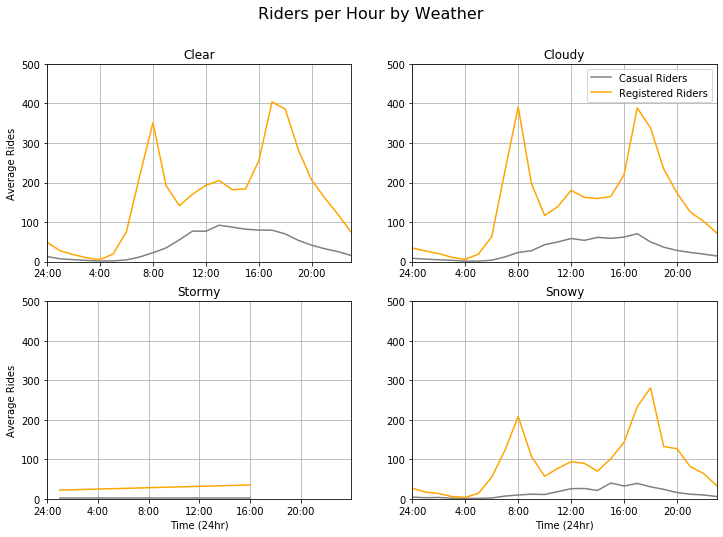

In [14]:
# Split data set per weather
cloudy_df = BSS_train.loc[BSS_train['Cloudy'] == 1].groupby('hour').agg(
    {'casual':'mean','registered':'mean'})
storm_df = BSS_train.loc[BSS_train['Storm'] == 1].groupby('hour').agg(
    {'casual':'mean','registered':'mean'})
snow_df = BSS_train.loc[BSS_train['Snow'] == 1].groupby('hour').agg(
    {'casual':'mean','registered':'mean'})
clear_df = BSS_train.loc[(BSS_train['Cloudy'] == 0) & 
              (BSS_train['Storm'] == 0) & 
              (BSS_train['Snow'] == 0)].groupby('hour').agg(
    {'casual':'mean','registered':'mean'})

plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Riders per Hour by Weather', fontsize=16)

axes[0,0].plot(clear_df.index, clear_df.casual, label = 'Casual Riders', color = 'grey')
axes[0,0].plot(clear_df.index, clear_df.registered, label = 'Registered Riders', color = 'orange')
axes[0,0].set_title('Clear')
axes[0,0].grid(True)
axes[0,0].set_ylim((0, 500))
axes[0,0].margins(0, 0.25)
axes[0,0].set_ylabel('Average Rides')
axes[0,0].set_xticks([0, 4, 8, 12, 16, 20])
axes[0,0].set_xticklabels(['24:00', '4:00', '8:00', '12:00', '16:00', '20:00'])

axes[0,1].plot(cloudy_df.index, cloudy_df.casual, label = 'Casual Riders', color = 'grey')
axes[0,1].plot(cloudy_df.index, cloudy_df.registered, label = 'Registered Riders', color = 'orange')
axes[0,1].set_title('Cloudy')
axes[0,1].grid(True)
axes[0,1].set_ylim((0, 500))
axes[0,1].margins(0, 0.25)
axes[0,1].legend()
axes[0,1].set_xticks([0, 4, 8, 12, 16, 20])
axes[0,1].set_xticklabels(['24:00', '4:00', '8:00', '12:00', '16:00', '20:00'])

axes[1,0].plot(storm_df.index, storm_df.casual, label = 'Casual Riders', color = 'grey')
axes[1,0].plot(storm_df.index, storm_df.registered, label = 'Registered Riders', color = 'orange')
axes[1,0].set_title('Stormy')
axes[1,0].grid(True)
axes[1,0].set_ylim((0, 500))
axes[1,0].set_xlim((0, 24))
axes[1,0].margins(0, 0.25)
axes[1,0].set_ylabel('Average Rides')
axes[1,0].set_xlabel('Time (24hr)')
axes[1,0].set_xticks([0, 4, 8, 12, 16, 20])
axes[1,0].set_xticklabels(['24:00', '4:00', '8:00', '12:00', '16:00', '20:00'])

axes[1,1].plot(snow_df.index, snow_df.casual, label = 'Casual Riders', color = 'grey')
axes[1,1].plot(snow_df.index, snow_df.registered, label = 'Registered Riders', color = 'orange')
axes[1,1].set_title('Snowy')
axes[1,1].grid(True)
axes[1,1].set_ylim((0, 500))
axes[1,1].margins(0, 0.25)
axes[1,1].set_xlabel('Time (24hr)')
axes[1,1].set_xticks([0, 4, 8, 12, 16, 20])
axes[1,1].set_xticklabels(['24:00', '4:00', '8:00', '12:00', '16:00', '20:00'])
plt.show()

As we would hypothesize, the ridership decreases as the weather moves from clear to snowy. Snow has about half as many riders at any given time than an average clear day. Cloudy and clear are actually fairly similar, with slightly fewer casual riders on cloudy days. 

There is not enough information for stormy days to make accurate prediction for this case. Presumably, this classification is not often used. 

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [15]:
# Filter predictors
predictor_vars = ['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'spring',
       'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']

# Reshape arrays
X_train = np.array(BSS_train[predictor_vars])
X_train = X_train.reshape(X_train.shape[0], len(predictor_vars))
Y_train = np.array(BSS_train.counts)

OLSModel = sm.OLS(BSS_train.counts, sm.add_constant(BSS_train[predictor_vars]))
OLSModel_Fit = OLSModel.fit()

# get the prediction results
test_predicted = OLSModel_Fit.predict(sm.add_constant(BSS_test[predictor_vars]))
r2_score_test = r2_score(BSS_test.counts, test_predicted)

print('R-Squared for outlier model on training set is: {0:1.3f}'.format(OLSModel_Fit.rsquared))
print('R-Squared for outlier model on test set is:     {0:1.3f}'.format(r2_score_test))

OLSModel_Fit.summary(xname= ['const'] + predictor_vars)

R-Squared for outlier model on training set is: 0.412
R-Squared for outlier model on test set is:     0.401


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:12:14   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

**3.2 Examine the estimated coefficients and report...**

In [16]:
# your code here
print('Variables statistically significant, with p-values < 0.05:')
print(OLSModel_Fit.pvalues.loc[OLSModel_Fit.pvalues <= 0.05])
print('\nVariables NOT statistically significant, with p-values > 0.05:')
OLSModel_Fit.pvalues.loc[OLSModel_Fit.pvalues > 0.05]

Variables statistically significant, with p-values < 0.05:
const          5.319401e-03
hour          6.967036e-200
holiday        2.214061e-02
year          3.862196e-142
workingday     1.828978e-03
temp           9.243128e-06
atemp          1.229662e-02
hum            5.926590e-90
spring         1.510519e-07
summer         4.168321e-02
fall           6.554799e-14
Apr            3.897799e-04
May            2.023805e-04
Jun            1.392848e-07
Jul            3.606677e-09
Aug            1.084419e-04
Nov            6.623427e-03
Dec            4.454012e-02
Sat            2.255964e-02
Snow           1.092443e-05
dtype: float64

Variables NOT statistically significant, with p-values > 0.05:


windspeed    0.153999
Feb          0.157874
Mar          0.178047
Sept         0.228734
Oct          0.203296
Mon          0.374830
Tue          0.998567
Wed          0.588907
Thu          0.165185
Fri          0.467959
Cloudy       0.059929
Storm        0.625768
dtype: float64

**3.3 You should see some strange estimates for the predictors representing months...** 


July has a coefficient of -90 counts (compared to Jan at 0). At first this, is highly-counterintuitive, except that there is a strong correlation between temperature and month of the year, and there is a strong positive correlation between temperature and ridership. In this context, the negative coefficient for July actually makes intuitive sense. We might theorize that individuals are MORE likely to ride bikes on warm days in the fall months than warm days in the summer months.

**3.4 To diagnose the model, make two plots:...**

<Figure size 432x288 with 0 Axes>

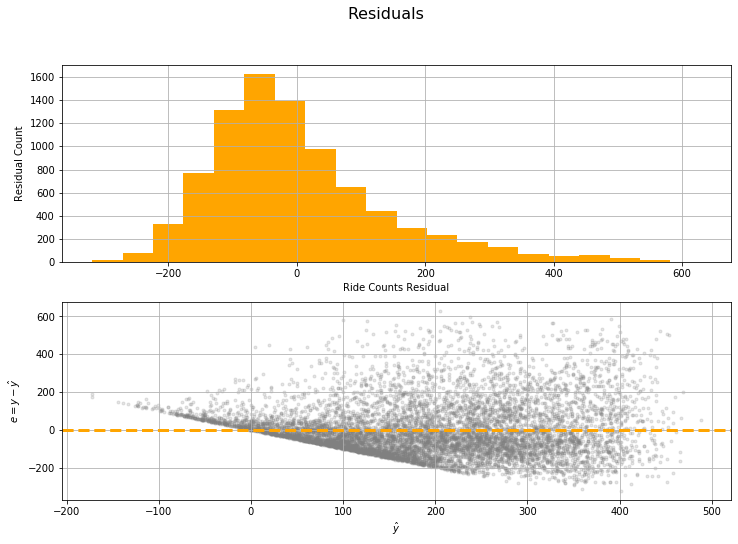

In [17]:
# your code here
BSS_train.iloc[0]

plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
fig.suptitle('Residuals', fontsize=16)

axes[0].hist(OLSModel_Fit.resid, bins=20, color='orange')
axes[0].grid(True)
axes[0].set_ylabel('Residual Count')
axes[0].set_xlabel('Ride Counts Residual')

axes[1].scatter(OLSModel_Fit.fittedvalues, OLSModel_Fit.resid, marker='.', color='grey', alpha=0.2)
axes[1].axhline(y=OLSModel_Fit.resid.mean(), color='orange', ls='--', linewidth=3)
axes[1].set_ylabel(r"""$e = y-\^y$""")
axes[1].set_xlabel(r"""$\^y$""")
axes[1].grid(True)
#OLSModel_Fit.resid
#OLSModel_Fit.fittedvalues
#OLSModel_Fit.predict(sm.add_constant(BSS_train[explanatory_vars]))
plt.show()

The residuals are not quite normally distributed. There is a larger tail on the right side. 

**3.5 Perhaps we can do better via a model...**

<Figure size 432x288 with 0 Axes>

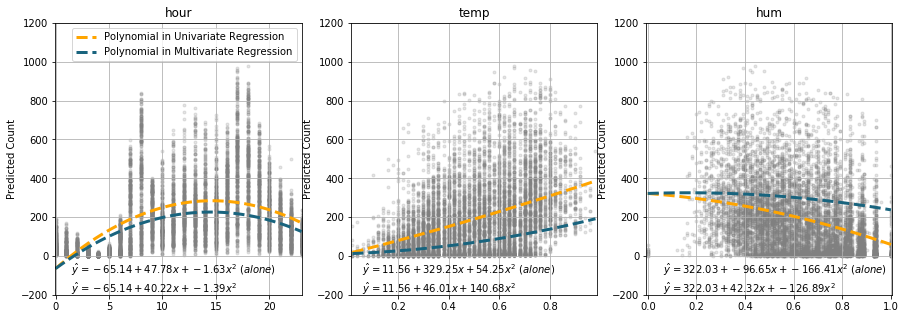

R-Squared for outlier model on training set is: 0.508


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:12:16   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
hour^2        -1.3881      0.034    -40.654      0.000      -1.455      -1.321
temp^2       140.6804     46.276      3.040      0.002      49.968     231.393
hum^2       -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

In [18]:
X_train_poly = X_train.copy()
squared_predictors = ['hour', 'temp', 'hum']
beta_0s = []
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
for pred in squared_predictors:
    # Index of squared_predictor 
    i = predictor_vars.index(pred)
    i_s = squared_predictors.index(pred)
    
    # Update New Model
    X_train_poly = np.concatenate((X_train_poly, np.power([X_train[:, i]], 2).T), axis=1)
    
    # Create Model for lone 
    OLSModel = sm.OLS(BSS_train.counts, sm.add_constant(
        np.concatenate((np.array([X_train_poly[:, i]]).T, 
                        np.array([X_train_poly[:, -1]]).T), axis=1)))
    OLSModel_Fit = OLSModel.fit()
    x = np.linspace(min(X_train_poly[:, i]), max(X_train_poly[:, i]), 100)
    y = OLSModel_Fit.params[0] + OLSModel_Fit.params[1]*x + OLSModel_Fit.params[2]*np.power(x, 2)
    beta_0s.append(OLSModel_Fit.params[0])

    axes[i_s].scatter(X_train_poly[:, i], BSS_train.counts, color='grey', marker='.', alpha=0.2)
    axes[i_s].plot(x, y, color='orange', ls='--', linewidth=3, label='Polynomial in Univariate Regression')
    axes[i_s].set_title(pred)
    axes[i_s].set_ylabel('Predicted Count')
    axes[i_s].set_ylim((-200, 1200))
    axes[i_s].grid(True)
    axes[i_s].margins(0, 0.25)
    axes[i_s].text(0,-100 + 8,r"""     $\^y={:1.2f} + {:1.2f}x + {:1.2f}x^2\ (alone)$""".format(
        OLSModel_Fit.params[0],OLSModel_Fit.params[1],OLSModel_Fit.params[2]))

OLSModel = sm.OLS(BSS_train.counts, sm.add_constant(X_train_poly))
OLSModel_Fit = OLSModel.fit()

for pred in squared_predictors:
    # Index of squared_predictor 
    i = predictor_vars.index(pred)
    i_s = squared_predictors.index(pred)
    
    x = np.linspace(min(X_train_poly[:, i]), max(X_train_poly[:, i]), 100)
    y = beta_0s[i_s] + OLSModel_Fit.params[i+1]*x + OLSModel_Fit.params[len(predictor_vars) + i_s + 1]*np.power(x, 2)
    
    axes[i_s].plot(x, y, color='#19647E', ls='--', linewidth=3, label='Polynomial in Multivariate Regression')
    axes[i_s].text(0,-200 + 8,r"""     $\^y={:1.2f} + {:1.2f}x + {:1.2f}x^2$""".format(
        beta_0s[i_s], OLSModel_Fit.params[i+1], OLSModel_Fit.params[len(predictor_vars) + i_s + 1]))
axes[0].legend()
plt.show()

print('R-Squared for outlier model on training set is: {0:1.3f}'.format(OLSModel_Fit.rsquared))

OLSModel_Fit.summary(xname= ['const'] + predictor_vars + np.core.defchararray.add(squared_predictors, '^2').tolist())

In the chart above we can see the effect of adding second-order polynomials to the variables 'hour', 'temp', 'hum'. The addition of these variables increases the R-squared value on the training set from 0.41 to 0.51. This is a nice improvement from the initial model. Each of the second-order coefficients has a statistically significant p-value and contributes to the predictive power of the model.

I've also plotted the polynomial equation for each predictor both as a univariate model and as part of the final multivariate model. For each we can see that the equation is slightly different when combined with the full model because of some multicollinearity with other variables. The 'hours' variable increases during the day hours then flattens and decreases towards the end of the day. 'temp' has an upwards sloping curve, and 'hum' has a slight downwards sloping curve.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [19]:
# your code here
X_train_drop = np.delete(X_train, 
                         [predictor_vars.index(i) for i in ['workingday', 'atemp', 'spring', 'summer', 'fall']], 
                         axis=1)
predictor_vars_drop = np.delete(predictor_vars, 
                         [predictor_vars.index(i) for i in ['workingday', 'atemp', 'spring', 'summer', 'fall']])

OLSModel = sm.OLS(BSS_train.counts, sm.add_constant(X_train_drop))
OLSModel_Fit = OLSModel.fit()

OLSModel_Fit.summary(xname= ['const'] + predictor_vars_drop.tolist())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:12:16   Log-Likelihood:                -55263.
No. Observations:                8689   AIC:                         1.106e+05
Df Residuals:                    8662   BIC:                         1.108e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.2056     10.772     -2.433      0.015     -47.322      -5.089
hour           7.2218      0.234     30.871      0.000       6.763       7.680
holiday      -37.2529      9.390     -3.967      0.000     -55.659     -18.846
year          77.9687      3.035     25.691      0.000      72.020      83.918
temp         425.3856     16.922     25.137      0.000     392.214     458.557
hum         -198.2002      9.944    -19.933      0.000    -217.692    -178.709
windspeed      3.0647     13.166      0.233      0.816     -22.743      28.872
Feb          -10.3801      7.624     -1.362      0.173     -25.324       4.564
Mar            4.8473      7.834      0.619      0.536     -10.510      20.205
Apr            5.6103      8.422      0.666      0.505     -10.899      22.119
May           -2.4330      9.725     -0.250      0.802     -21.497      16.631
Jun          -35.3982     10.671     -3.317      0.001     -56.316     -14.480
Jul          -72.2768     11.583     -6.240      0.000     -94.982     -49.571
Aug          -40.9043     11.043     -3.704      0.000     -62.551     -19.258
Sept          15.9133     10.059      1.582      0.114      -3.805      35.632
Oct           54.0377      8.686      6.221      0.000      37.010      71.065
Nov           38.3870      7.796      4.924      0.000      23.106      53.668
Dec           26.2086      7.582      3.457      0.001      11.346      41.071
Mon            9.6638      5.802      1.666      0.096      -1.709      21.036
Tue           11.4788      5.705      2.012      0.044       0.295      22.663
Wed            8.5964      5.676      1.515      0.130      -2.529      19.722
Thu            5.9261      5.641      1.050      0.294      -5.132      16.984
Fri           13.5104      5.640      2.396      0.017       2.455      24.566
Sat           12.3255      5.614      2.196      0.028       1.321      23.330
Cloudy         7.0689      3.692      1.915      0.056      -0.169      14.306
Snow         -27.3958      6.112     -4.483      0.000     -39.376     -15.415
Storm         44.8939     99.348      0.452      0.651    -149.852     239.640
==============================================================================
Omnibus:                     1712.709   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3312.120
Skew:                           1.202   Prob(JB):                         0.00
Kurtosis:                       4.837   Cond. No.                         898.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With `workingday` `atemp` `spring` `summer` and `fall` removed, we have resolved the multicolinearity warning. The coefficients make a lot more sense, with the winter months showing low or negative contribution to count as we might expect. `atemp` had almost perfect correlation with `temp`, so was completely unnecessary for this model. More importantly, there was strong colinearity between the months and the seasons. This was causing us to get strange estimates. The same issue occured between `workingday` and the day of the week values.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [20]:
try:
    BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1, inplace=True)
except ValueError:
    print('\'workingday\', \'atemp\', \'spring\', \'summer\', \'fall\' already removed')
try:
    BSS_test.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1, inplace=True)
except ValueError:
    print('\'workingday\', \'atemp\', \'spring\', \'summer\', \'fall\' already removed')
BSS_train.columns

Index(['dteday', 'hour', 'holiday', 'year', 'temp', 'hum', 'windspeed',
       'casual', 'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

**4.2 Write a function to standardize...**

In [21]:
def standardize(df, include='all', df_from='self', exclude=[]):
    """
    df_arr is a pandas dataframe to apply scaling to
    cols determins which columns will be standardized
    """
    original_cols = df.columns
    if include == 'all':
        cols = df.columns
    else:
        cols = include
    cols = cols.difference(exclude)
    cols = df[cols].select_dtypes(exclude=['object']).columns
    
    if df_from is 'self':
        scaler = StandardScaler().fit(df[cols])
    else:
        scaler = StandardScaler().fit(df_from[cols])
    return pd.concat([df[df.columns.difference(cols)], 
                      pd.DataFrame(scaler.transform(df[cols]), columns=cols)], 
                     axis=1).reindex(original_cols, axis=1)

binary_columns = [ 'holiday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
        'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']   
practice_X_train_scaled = standardize(BSS_train, exclude=binary_columns)
display(pd.DataFrame(practice_X_train_scaled).describe())

,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,Feb,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,8.689000e+03,8689.000000,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03,8689.000000,...,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000,8689.000000
mean,2.762461e-17,0.029347,-2.754411e-16,-7.622961e-17,-4.148227e-16,-5.604141e-17,9.976547e-17,-7.426190e-17,7.902784e-17,0.077224,...,0.085280,0.144205,0.137875,0.141788,0.144551,0.143975,0.146047,0.257567,0.083324,0.000230
std,1.000058e+00,0.168788,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00,0.266962,...,0.279314,0.351318,0.344789,0.348853,0.351667,0.351085,0.353173,0.437319,0.276387,0.015171
min,-1.666359e+00,0.000000,-1.006813e+00,-2.474192e+00,-3.251974e+00,-1.546636e+00,-7.225429e-01,-1.020078e+00,-1.043874e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.042663e-01,0.000000,-1.006813e+00,-8.122824e-01,-7.554808e-01,-6.987336e-01,-6.419191e-01,-7.956442e-01,-8.289057e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.782674e-02,0.000000,9.932327e-01,1.867233e-02,-2.733697e-02,2.746035e-02,-3.798917e-01,-2.477612e-01,-2.556558e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.199197e-01,0.000000,9.932327e-01,8.496271e-01,8.048274e-01,5.118601e-01,2.650986e-01,4.387427e-01,5.160268e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.638331e+00,1.000000,9.932327e-01,2.511537e+00,1.949053e+00,5.355858e+00,6.573911e+00,4.828407e+00,4.335856e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4.3 Write code to augment your a dataset with higher-order features for...**

In [22]:
squared_predictors = ['hour', 'temp', 'windspeed', 'hum']

def add_poly_terms(df, cols='all', N=2):
    df = df.copy()
    
    if cols == 'all':
        cols = df.columns
    for p in range(2, N+1):
        for col in cols:
            df['{}^{}'.format(col, p)] = df[col]**p
    return df

practice_X_train_poly = add_poly_terms(practice_X_train_scaled, cols=squared_predictors, N=3)

print(practice_X_train_poly.columns)
practice_X_train_poly.head(5)

Index(['dteday', 'hour', 'holiday', 'year', 'temp', 'hum', 'windspeed',
       'casual', 'registered', 'counts', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu',
       'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'hour^2', 'temp^2',
       'windspeed^2', 'hum^2', 'hour^3', 'temp^3', 'windspeed^3', 'hum^3'],
      dtype='object')


,dteday,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,...,Snow,Storm,hour^2,temp^2,windspeed^2,hum^2,hour^3,temp^3,windspeed^3,hum^3
0,2012-12-27,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,-0.480671,-0.683427,-0.702129,...,0,0,1.825110,1.773236,0.262001,0.017255,2.465662,-2.361293,0.134108,-0.002267
1,2011-10-13,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0.224787,1.831554,1.590870,...,1,0,0.602545,0.412021,0.262001,1.133967,0.467718,0.264471,0.134108,1.207537
2,2012-08-09,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0.365878,0.953621,0.896356,...,0,0,0.139293,1.874089,0.045939,0.032654,-0.051987,2.565579,-0.009846,0.005901
3,2012-04-08,0.776238,0,0.993233,0.641888,-2.107748,0.875363,3.006308,0.471748,1.216053,...,0,0,0.602545,0.412021,0.766260,4.442601,0.467718,0.264471,0.670755,-9.363882
4,2012-01-29,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,-0.541139,-0.617417,-0.663545,...,0,0,0.267188,2.700228,0.208794,1.372560,-0.138110,-4.437116,-0.095406,-1.608040


**4.4 Write code to add interaction terms to the model...**

In [23]:
# your code here
def interactions(df, a_cols='all', b_cols='all', exclude=[]):
    df = df.copy()
    
    if a_cols == 'all':
        a_cols = df.columns
    if b_cols == 'all':
        b_cols = df.columns
    
    # Remove non-numerical datatypes
    a_cols = df[a_cols].select_dtypes(exclude=['object']).columns.difference(exclude)
    b_cols = df[b_cols].select_dtypes(exclude=['object']).columns.difference(exclude)
    a_cols = df[a_cols].columns.difference(b_cols)
    b_cols = df[b_cols].columns.difference(a_cols)
    
    for i_col in a_cols:
        for col in b_cols:
            df['{}*{}'.format(col, i_col)] = df[col]*df[i_col]
    return df
        
practice_X_train_poly_t = interactions(practice_X_train_poly, binary_columns, ['temp', 'hum', 'windspeed'])
print(practice_X_train_poly_t.columns)
practice_X_train_poly_t.head(5)

Index(['dteday', 'hour', 'holiday', 'year', 'temp', 'hum', 'windspeed',
       'casual', 'registered', 'counts',
       ...
       'windspeed*Thu', 'hum*Tue', 'temp*Tue', 'windspeed*Tue', 'hum*Wed',
       'temp*Wed', 'windspeed*Wed', 'hum*holiday', 'temp*holiday',
       'windspeed*holiday'],
      dtype='object', length=101)


,dteday,hour,holiday,year,temp,hum,windspeed,casual,registered,counts,...,windspeed*Thu,hum*Tue,temp*Tue,windspeed*Tue,hum*Wed,temp*Wed,windspeed*Wed,hum*holiday,temp*holiday,windspeed*holiday
0,2012-12-27,1.350966,0,0.993233,-1.331629,-0.131358,0.511860,-0.480671,-0.683427,-0.702129,...,0.511860,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
1,2011-10-13,0.776238,0,-1.006813,0.641888,1.064879,0.511860,0.224787,1.831554,1.590870,...,0.511860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-08-09,-0.373220,0,0.993233,1.368974,0.180704,-0.214334,0.365878,0.953621,0.896356,...,-0.214334,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0
3,2012-04-08,0.776238,0,0.993233,0.641888,-2.107748,0.875363,3.006308,0.471748,1.216053,...,0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
4,2012-01-29,-0.516902,0,0.993233,-1.643237,-1.171563,-0.456939,-0.541139,-0.617417,-0.663545,...,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


**4.5 Combine all your code so far into a function named...**

In [24]:
def get_design_mats(train_df, val_df, degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts','casual','registered','dteday'],
                    binary_terms=['holiday','Feb', 'Mar', 'Apr',
                                  'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
                                  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 
                                  'Cloudy', 'Snow', 'Storm'],
                    continuous_terms=['temp', 'hum','windspeed']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    # Remove bad columns from other list inputs
    columns_forpoly  = list(set(columns_forpoly) - set(bad_columns))
    binary_terms = list(set(binary_terms) - set(bad_columns))
    continuous_terms = list(set(continuous_terms) - set(bad_columns))
    
    # Copy to new arrays to preserve input values
    train_df = train_df.copy()
    val_df = val_df.copy()
    
    # Create response column
    y_train = pd.DataFrame(train_df[target_col])
    y_val = pd.DataFrame(val_df[target_col])
      
    # Drop bad columns
    x_train = train_df[train_df.columns.difference(bad_columns)]
    x_val = val_df[val_df.columns.difference(bad_columns)]
    
    # Standardize
    x_val = standardize(x_val, df_from=x_train, exclude=binary_terms)
    x_train = standardize(x_train, exclude=binary_terms)
    
    y_val = standardize(y_val, df_from=y_train)
    y_train = standardize(y_train)
    
    # Add Polynomials
    x_train = add_poly_terms(x_train, cols=columns_forpoly, N=degree)
    x_val = add_poly_terms(x_val, cols=columns_forpoly, N=degree)
    
    # Add Interaction Terms
    x_train = interactions(x_train, binary_terms, continuous_terms)
    x_val = interactions(x_val, binary_terms, continuous_terms)
    
    return x_train, y_train, x_val, y_val

**4.6 For each degree in 1 through 8...**

In [25]:
for degree in range(1,9):
    print('Degree:', degree)
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train, BSS_test, degree)
    
    OLSModel = sm.OLS(y_train.counts, sm.add_constant(np.array(x_train)))
    OLSModel_Fit = OLSModel.fit()
    
    test_predicted = OLSModel_Fit.predict(sm.add_constant(np.array(x_val)))
    r2_score_test = r2_score(np.array(y_val.counts), np.array(test_predicted))
    
    print('R-Squared for model on training set is: {0:1.3f}'.format(OLSModel_Fit.rsquared))
    print('R-Squared for model on test set is:     {0:1.3f}'.format(r2_score_test))

Degree: 1
R-Squared for model on training set is: 0.439
R-Squared for model on test set is:     0.430
Degree: 2
R-Squared for model on training set is: 0.527
R-Squared for model on test set is:     0.513
Degree: 3
R-Squared for model on training set is: 0.571
R-Squared for model on test set is:     0.563
Degree: 4
R-Squared for model on training set is: 0.573
R-Squared for model on test set is:     0.566
Degree: 5
R-Squared for model on training set is: 0.588
R-Squared for model on test set is:     0.578
Degree: 6
R-Squared for model on training set is: 0.610
R-Squared for model on test set is:     0.600
Degree: 7
R-Squared for model on training set is: 0.649
R-Squared for model on test set is:     0.635
Degree: 8
R-Squared for model on training set is: 0.658
R-Squared for model on test set is:     0.645


**4.7 Discuss patterns you see in the results...**

With the 8th order polynomial terms added we get up to 0.645 R-squared on the test dataset. With each added polynomial we get incremental increase in R-squared on both the training and the test set. This seems to indicate that higher order polynomials in the polynomial columns provided do have predictive power. However, in order to make a simpler model that might be more robust to new data, I would remove all of the polynomial columns except `hours`, which do not add much value to the model. 

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

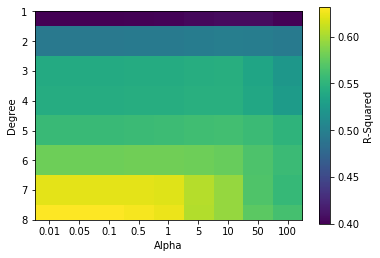

array([[ 0.39940634,  0.39952598,  0.39966422,  0.40050554,  0.40126321,
         0.40461688,  0.40638878,  0.40589804,  0.40119492],
       [ 0.49352203,  0.49360336,  0.49369788,  0.4942874 ,  0.49482565,
         0.49715659,  0.49843699,  0.49829262,  0.49451379],
       [ 0.54151316,  0.54158295,  0.54166635,  0.54222234,  0.5427458 ,
         0.5445909 ,  0.54479805,  0.53570258,  0.52278486],
       [ 0.54320308,  0.54327171,  0.54335323,  0.54388623,  0.54437887,
         0.54616472,  0.54646609,  0.53835134,  0.52658822],
       [ 0.55694451,  0.55703592,  0.5571437 ,  0.55782406,  0.55841945,
         0.5605907 ,  0.56136375,  0.55753859,  0.55081103],
       [ 0.5807813 ,  0.58082079,  0.58086597,  0.5811053 ,  0.58122183,
         0.58022467,  0.57813759,  0.56695375,  0.55805863],
       [ 0.6220061 ,  0.6220785 ,  0.6221423 ,  0.62188471,  0.62050153,
         0.6060275 ,  0.59482281,  0.56780923,  0.55525515],
       [ 0.63184651,  0.63164879,  0.63136907,  0.62850491,  0

In [26]:
# Split training set
BSS_train_split, BSS_val = train_test_split(BSS_train, 
                                           random_state = 90,
                                           test_size = 0.8)
alphas = [.01,.05,.1,.5,1,5,10,50,100]
R_squared = np.zeros((8,len(alphas)))

for degree in range(1,9):
    x_train, y_train, x_val, y_val = get_design_mats(BSS_train_split.reset_index(), BSS_val.reset_index(), degree)
    
    for alpha in alphas:
        ridge_model = Ridge(alpha=alpha).fit(x_train, y_train)
        R_squared[degree - 1][alphas.index(alpha)] = ridge_model.score(x_val, y_val)
    
ax = plt.gca()
im = ax.imshow(R_squared)
cbar = ax.figure.colorbar(im, ax=ax, label='R-Squared')
ax.set_xticks(np.arange(len(alphas)))
ax.set_xticklabels(alphas)
ax.set_yticks(np.arange(len(range(1,9))))
ax.set_yticklabels(range(1,9))
ax.set_xlabel('Alpha')
ax.set_ylabel('Degree')
plt.show()

R_squared

**5.2 Find the best-scoring degree and regularization combination.**

In [27]:
degree_i = (int)(np.argmax(R_squared)/len(alphas))
alpha_i = (int)(np.argmax(R_squared)%len(alphas))
print('Optimal R-squared value {:1.3} at degree={} and alpha={}'.format(
    R_squared[degree_i][alpha_i], degree_i + 1, alphas[alpha_i]))

Optimal R-squared value 0.632 at degree=8 and alpha=0.01


**5.3 It's time to see how well our selected model...**


In [28]:
x_train, y_train, x_test, y_test = get_design_mats(BSS_train_split.reset_index(), BSS_test.reset_index(), degree_i + 1)

ridge_model = Ridge(alpha=alphas[alpha_i]).fit(x_train, y_train)

print('Optimal R-squared value for test set degree={} and alpha={}: {:1.3} '.format(
    degree_i + 1, alphas[alpha_i], ridge_model.score(x_test, y_test)))

Optimal R-squared value for test set degree=8 and alpha=0.01: 0.622 


The R-squared value is slightly lower for the test set (0.622 vs 0.632). This small deviation could be due to sample noise or could be due to some of the decisions we made while optimizing the model for the validation set.

**5.4 Build a dataset with polynomial degree 1...**

In [59]:
x_train, y_train, x_val, y_val = get_design_mats(BSS_train_split.reset_index(), BSS_val.reset_index(), 1)

OLSModel = sm.OLS(y_train.counts, sm.add_constant(np.array(x_train)))
OLSModel_Fit = OLSModel.fit()

test_predicted = OLSModel_Fit.predict(sm.add_constant(np.array(x_val)))
r2_score_test = r2_score(np.array(y_val.counts), np.array(test_predicted))

fitted_ridge = RidgeCV(alphas=alphas).fit(sm.add_constant(np.array(x_train)), np.array(y_train))
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(sm.add_constant(np.array(x_train)), np.array(y_train))

print('R^2 score for our original OLS model: {:1.3}\n'.format(r2_score_test))

ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {:1.3}\n'.format(
    ridge_a, fitted_ridge.score(sm.add_constant(np.array(x_val)), np.array(y_val))))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {:1.3}'.format(
    lasso_a, fitted_lasso.score(sm.add_constant(np.array(x_val)), np.array(y_val))))

R^2 score for our original OLS model: 0.399

Best alpha for ridge: 10.0
R^2 score for Ridge with alpha=10.0: 0.406

Best alpha for lasso: 0.01
R squared score for Lasso with alpha=0.01: 0.39


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**5.5 Plot histograms of the coefficients found...**

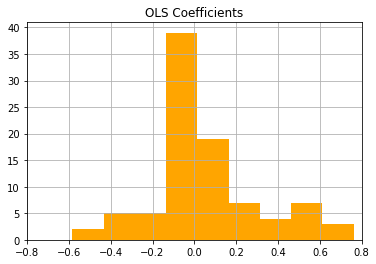

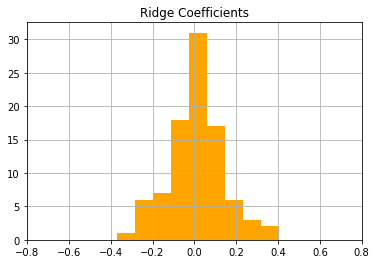

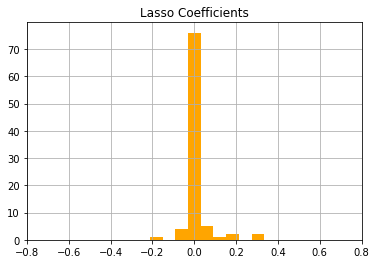

In [38]:
# your code here
dir(fitted_ridge)
plt.hist(OLSModel_Fit.params.tolist(), bins=9, color='orange')
plt.grid(True)
plt.title('OLS Coefficients')
plt.xlim((-0.8, 0.8))
plt.show()
plt.hist(fitted_ridge.coef_[0], bins=9, color='orange')
plt.grid(True)
plt.title('Ridge Coefficients')
plt.xlim((-0.8, 0.8))
plt.show()
plt.hist(fitted_lasso.coef_, bins=9, color='orange')
plt.grid(True)
plt.title('Lasso Coefficients')
plt.xlim((-0.8, 0.8))
plt.show()

Ridge has terms closer to 0 than OLS, but Lasso has way more terms zeroed out completely. This makes sense given what we have seen for Lasso and Ridge

**5.6 The plots above show the overall distribution of... **

<Figure size 432x288 with 0 Axes>

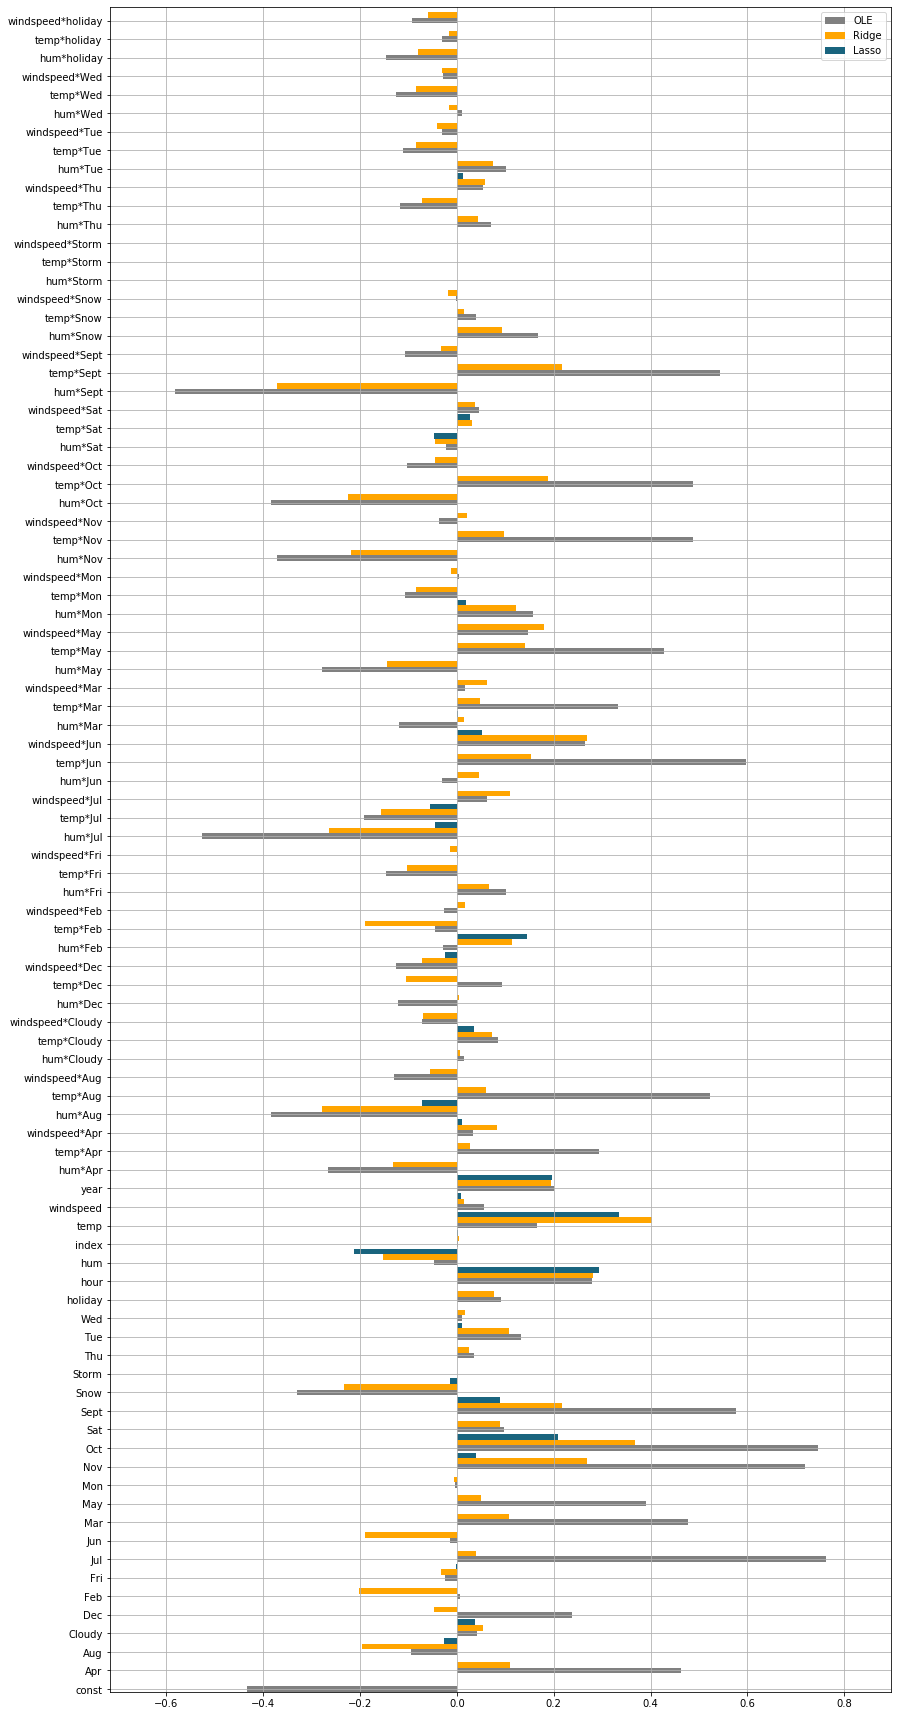

In [39]:
# your code here
plt.clf()
params = ['const'] + x_train.columns.tolist()
width = 0.3
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 31))
ax.barh(np.arange(len(params)), OLSModel_Fit.params.tolist(), width, label='OLE', color='grey')
ax.barh(np.arange(len(params)) + width, fitted_ridge.coef_[0], width, label='Ridge', color='orange')
ax.barh(np.arange(len(params)) + 2*width, fitted_lasso.coef_, width, label='Lasso', color='#19647E')
ax.margins(0.1, 0)
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels(params)
ax.legend()
plt.grid(True)
plt.show()

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7 What trends do you see...**

Generally, the parameters are pretty much all fairly well correlated between the different methods. Ridge parameters approach 0 and Lasso parameters are more likely to be zeroed out all-together. We see some of the key parameters remain strong through all 3 models, like `hour`, `temp`, and `year`.

We removed the atemp variable from our model earlier in this problem. If we had included it, either temp or atemp would've likely moved become 0.

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

`get_design_mats` allowed us to to test various settings for the model without having to re-write code. It was especially useful for testing polynomial degrees in a loop. The default function inputs allowed us to start with a common base and isolate changes we wanted to test. Especially with Dataframes it can get quite confusing to recall the latest state of the data-set, and it's easier to start from the original, unmodified dataset each iteration.

**6.2 What are the costs and benefits of applying ridge/lasso...**

Lasso does a better job helping with variable selection because it takes often minimizes with variable params = 0. OLS and forward selecting will keep parameters for each polynomial up to the highest order, even if some of the intermediate polynomials are not statistically significant. This can create more complex and overfit models. Because inclusion of parameters are effectively penalized in Ridge and Lasso, they need to add significant value to the model to be included.

**6.3 This pset posed a purely predictive goal: forecast ridership...**

I would be deeply suspicious if we couldn't logically interperate the variables in our model. At the end of the day we are predicting ridership of both commuters and casual riders. It's possible that our model could uncover deeper user interactions that we would not have hypothesized, but they should be rooted in user behavior that we can observe and study further.

**6.4 Reflect back on our original goal of helping BikeShare predict...**

Our best R-squared value acheived was 0.62, using degree 8 and a ridge regulation. In the case of predicting the number daily demand for the week ahead, this model is not great, but should be sufficient to give a rought prediction of the number of rides we can expect for a day. Looking at the residual plot in 3.4 shows us that we should be within +/- 200 rides for most days.